In [1]:
# import all the libraries
from collections import defaultdict
import string
import os
import torch
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

In [2]:
# loading the file, reading the content, and ordering them based on the image file.
def load_file(path: str):
    file = open(path, 'r')
    text = file.read()
    file.close()
    return text

def get_data(file_path: str) -> dict[str, [str]]:
    text = load_file(file_path)
    data = text.split('\n')
    img_cap_dict = defaultdict(list)
    for line in data:
        line.strip()
        if not line:
            continue
        if '\t' in line:
            img, caption = line.split('\t')
        else:
            content = line.split(maxsplit=1)
            if len(content) > 2:
                continue
            else:
                print(content)
                img, caption = content[0], content[1]
                
        img = img.split('#', 1)[0].strip()
        img_cap_dict[img].append(caption)
    return img_cap_dict

img_cap_dict = get_data('./data/Flickr8k.token.txt')  


In [3]:
# data preprocessing - lowercase, adding <start> and <end> tokens, removing punctuations, removing numericals

def process_data(data):
    translator = str.maketrans('', '', string.punctuation)
    for k in data.keys():
        values = data[k]
        for i, v in enumerate(values):
            # convert to lowercase
            v = v.lower()
            # remove punctuation
            v = v.translate(translator)
            # remove numbers
            v =  v.split()
            v = [w for w in v if w.isalpha()]
            # remove wierd words
            # v = [w for w in v if (len(w)>1)]
            if len(v) > 0:
                v = ['<start>'] + v + ['<end>']
            v = " ".join(v)
            data[k][i] = v
    return data
img_cap_dict = process_data(img_cap_dict)
m = 0
for k in img_cap_dict.keys():
    for v in img_cap_dict[k]:
        m = max(len(v), m)
m
# max lenght is 210 characters, can use it for sequence generation
        

206

In [4]:
# now the tokenization part, lets build a custom function for tokenization

def build_vocab_freq(caption_tokens):
    vocab_freq = defaultdict(int)
    for caption_token in caption_tokens:
        for w in caption_token:
            vocab_freq[w] += 1
    # print('len of vocab freq:::', len(vocab_freq))
    # print(vocab_freq)
    return vocab_freq

def tokenize(captions):
    caption_tokens = []
    for c in captions:
        caption_tokens.append(c.split())
    return caption_tokens

def remove_less_frequent(vocab_freq, min_freq=3, keep_tokens=("<start>", "<end>", "<pad>", "<unk>")):
    keep = set(keep_tokens)
    return {w: f for w, f in vocab_freq.items() if (f >= min_freq) or (w in keep)}

captions = []
for k in img_cap_dict.keys():
    for c in img_cap_dict[k]:
        captions.append(c)

caption_tokens = tokenize(captions)
vocab_freq = build_vocab_freq(caption_tokens)
# vocab_freq = remove_less_frequent(vocab_freq)



In [5]:
# now assign a unique id to all the words, add <pad> and <unk>
def assign_ids(vocab_freq):
    wtoi = {'<pad>': 0, '<unk>': 1}
    itow = {0: '<pad>', 1: '<unk>'}
    
    # Deterministic ordering: by frequency desc, then alphabetically
    words = sorted(vocab_freq.items(), key=lambda x: (-x[1], x[0]))
    for idx, (w, _) in enumerate(words, start=2):
        if w in wtoi:   # don't re-add specials if present
            continue
        wtoi[w] = idx
        itow[idx] = w
    return wtoi, itow

wtoi, itow = assign_ids(vocab_freq)

# print("vocab size:", len(wtoi))
# print({k: wtoi[k] for k in ['<pad>', '<unk>', '<start>', '<end>'] if k in wtoi})
# print(wtoi)

In [6]:
# pending part is to read images and get the image features, then use encodings to get the embeddgins to input captions, we feed 
# the input features and embeddings to a LSTM model. Let's do this tomorrow!!!

import numpy as np

# caption_tokens is a list of lists, e.g. [["<start>", "a", ... , "<end>"], ...]
lengths = np.array([len(tokens) for tokens in caption_tokens], dtype=np.int32)

# get the precentile lengths and assign the seq lenght as the 99th precentile length
p95 = int(np.ceil(np.percentile(lengths, 95)))
p99 = int(np.ceil(np.percentile(lengths, 99)))
print("p99_int:", p99)

max_len = p99


p99_int: 24


In [7]:
resnet50_weights = ResNet50_Weights.DEFAULT
base = resnet50(weights=resnet50_weights)

image_feature_ext_model = nn.Sequential(*list(base.children())[:-2])
preprocess = resnet50_weights.transforms()

# Define the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Mac GPU)")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")

image_feature_ext_model.to(device)
image_feature_ext_model.eval()

def extract_image_features(image_features, images_directory='./data/images/'):
    images = os.listdir(images_directory)
    allowed_ext = {'.jpg', '.jpeg', '.png'}
    for img in images:
        ext = os.path.splitext(img)[1].lower()
        if ext not in allowed_ext:
            continue
        image_dir = os.path.join(images_directory, img)
        image = Image.open(image_dir).convert('RGB')
        image = preprocess(image)
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            feature = image_feature_ext_model(image)
            feature = feature.squeeze(0)
            feature = feature.flatten(1).transpose(0, 1)     # (49, 2048)

            image_features[img] = feature

IMAGE_PATH = './data/images/'
FEATURES_PATH = './data/image_featuers_resent50.pt'

image_features = {}
if os.path.exists(FEATURES_PATH):
    image_features = torch.load(FEATURES_PATH, map_location="cpu")
    print("loading the image features from saved files")
else:
    image_features = {}
    extract_image_features(image_features, IMAGE_PATH)
    torch.save(image_features, FEATURES_PATH)

# extract_image_features(image_features)
print(len(image_features), next(iter(image_features.values())).shape)
print("Loaded features:", len(image_features))
print("One feature shape:", next(iter(image_features.values())).shape)
# print("inspecg a image feature", image_features['3569329986_1f468729b2.jpg'])
        
        
        

Using MPS (Mac GPU)
loading the image features from saved files
8091 torch.Size([49, 2048])
Loaded features: 8091
One feature shape: torch.Size([49, 2048])


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class ImageCaptionDataset(Dataset):
    def __init__(self, pairs, image_features, wtoi, max_len = 24):
        self.pairs = pairs
        self.feature_store = image_features
        self.wtoi = wtoi
        self.max_len = max_len
        self.pad_id = wtoi["<pad>"]
        self.unk_id = wtoi["<unk>"]

    def __len__(self):
        return len(self.pairs)

    def to_ids(self, caption_tokens):
        ids = []
        caption_tokens = caption_tokens.split()
        for token in caption_tokens:
            ids.append(self.wtoi.get(token, self.unk_id))
        return ids

    def __getitem__(self, idx):
        # image_id, input_tokens, output_token = self.pairs[idx]
        image_id, input_tokens = self.pairs[idx]
        ids = self.to_ids(input_tokens)
        image_feature = self.feature_store[image_id]

        # input/target shift
        input_ids = ids[:-1]
        target_ids = ids[1:]

        # truncate to max_len
        input_ids = input_ids[:self.max_len]
        target_ids = target_ids[:self.max_len]


        # padding
        pad_needed = self.max_len - len(input_ids)
        if pad_needed > 0:
            input_ids += [self.pad_id] * pad_needed
            target_ids += [self.pad_id] * pad_needed

        lengths = min(len(ids) - 1, self.max_len)
        
        return (
            image_feature,
            torch.tensor(input_ids, dtype=torch.long),
            torch.tensor(target_ids, dtype=torch.long),
            torch.tensor(lengths, dtype=torch.long)
        )
#load the data 
def load_photos(filename):
    file = load_file(filename)
    photos = file.split("\n")[:-1]
    photos_present = [
        p for p in photos
        if os.path.exists(os.path.join(IMAGE_PATH, p))
        and p in image_features           # <-- important
        and p in img_cap_dict             # <-- also important
    ]
    return photos_present

def construct_data_for_model(pairs):
    data_format_for_model = []
    for img_fe, caps in pairs:
        caps_token = caps.split()
        # print(caps_token)
        # return
        for i in range(1, len(caps_token)):
            data_format_for_model.append((img_fe, caps_token[:i], caps_token[i]))
    return data_format_for_model


train_images = set(load_photos('./data/Flickr_8k.trainImages.txt'))
dev_images = set(load_photos('./data/Flickr_8k.devImages.txt'))
test_images = set(load_photos('./data/Flickr_8k.testImages.txt'))

train_pairs = [
    (image_id, cap)
    for image_id, captions in img_cap_dict.items()
    if image_id in train_images
    for cap in captions
]
# train_pairs = construct_data_for_model(train_pairs)

dev_pairs = [
    (image_id, cap)
    for image_id, captions in img_cap_dict.items()
    if image_id in dev_images
    for cap in captions
]

test_pairs = [
    (image_id, cap)
    for image_id, captions in img_cap_dict.items()
    if image_id in test_images
    for cap in captions
]
# dev_pairs = construct_data_for_model(dev_pairs)


train_dataset = ImageCaptionDataset(train_pairs, image_features, wtoi, 24)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

dev_dataset = ImageCaptionDataset(dev_pairs, image_features, wtoi, 24)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, num_workers=0)

test_dataset = ImageCaptionDataset(test_pairs, image_features, wtoi, 24)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# One batch
image_feats, input_ids, target_ids, lengths = next(iter(train_loader))
print(image_feats.shape, input_ids.shape, target_ids.shape, lengths.shape)
print("Dev images:", len(dev_images))
print("Dev pairs:", len(dev_pairs))
print("test images:", len(test_images))
print("test pairs:", len(test_pairs))




torch.Size([32, 49, 2048]) torch.Size([32, 24]) torch.Size([32, 24]) torch.Size([32])
Dev images: 1000
Dev pairs: 5000
test images: 1000
test pairs: 5000


In [9]:
import math
import torch
from cnn_lstm_without_att import CaptioningModel, run_model

vocab_size = len(wtoi)
emb_dim = 256
pad_id = wtoi["<pad>"]
MODEL_SAVE_PATH = './data/model/best_model.pt'

model = CaptioningModel(
    vocab_size,
    emb_dim,
    image_input=2048,
    pad_id=wtoi["<pad>"],
    dropout=0.4
).to(device)

loss = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


epochs = 20
best_val_loss = float("inf")

# for epoch in range(epochs):
#     train_loss, train_acc = run_model(model, loss, train_loader,  optimizer, device)
#     val_loss, val_acc = run_model(model, loss, dev_loader, None, device)

#     # save if this is the best validation loss so far
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_epoch = epoch + 1
#         torch.save({
#             "epoch": best_epoch,
#             "model_state_dict": model.state_dict(),
#             "optimizer_state_dict": optimizer.state_dict(),
#             "val_loss": best_val_loss,
#             "wtoi": wtoi,   # optional but useful for later inference
#             "emb_dim": emb_dim,
#             "vocab_size": vocab_size,
#         }, MODEL_SAVE_PATH)

    
#     print(
#         f"Epoch {epoch+1:02d}/{epochs} | "
#         f"train loss: {train_loss:.4f} | train acc: {train_acc:.3f} | "
#         f"val loss: {val_loss:.4f} | val acc: {val_acc:.3f}"
#     )
        
    

In [10]:
# Train by adding attention to the CNN_LSTM, also replace LSTM with Transformers and train on that
from cnn_lstm_with_attention import LstmDecoderWithAttention
from transformer_arc import CaptionTransformerDecoder
from utils import run_epoch_attention

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
pad_id = wtoi["<pad>"]

enc_dim = 2048
emb_dim = 256
dec_dim = 256
att_dim = 256
vocab_size = len(wtoi)
best_val_loss = float("inf")

# load model CNN -> attention -> LSTM 
model = LstmDecoderWithAttention(
    vocab_size=vocab_size,
    enc_dim=enc_dim,
    emb_dim=emb_dim,
    dec_dim=dec_dim,
    att_dim=att_dim,
    pad_id=pad_id,
).to(device)

# load model CNN -> Transformers
model = CaptionTransformerDecoder(
    image_pix_dim=2048,
    image_pixels=49,
    d_model=256,
    n_heads=4,
    dim_feed_forw=1024,
    layers=3,
    vocab_size=vocab_size,
    seq_len=24,
    pad_id=pad_id,
    dropout=0.3
).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# epochs = 12
# best_val_loss = float("inf")
TRANSFORMER_MODEL_SAVE_PATH = './data/model/best_transformer_decoder.pt'
ATTENTION_MODEL_SAVE_PATH = './data/model/best_model_with_attention.pt'
# for epoch in range(epochs):
    # train_loss, train_acc = run_epoch_attention(model, train_loader, pad_id, optimizer=optimizer, device=device)
    # val_loss, val_acc     = run_epoch_attention(model, dev_loader,   pad_id, optimizer=None,     device=device)

    # save if this is the best validation loss so far
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     best_epoch = epoch + 1
    #     torch.save({
    #         "epoch": best_epoch,
    #         "model_state_dict": model.state_dict(),
    #         "optimizer_state_dict": optimizer.state_dict(),
    #         "val_loss": best_val_loss,
    #         "wtoi": wtoi,
    #         "vocab_size": vocab_size,
    #         "d_model": 256,
    #         "n_heads": 4,
    #         "layers": 3,
    #         "dim_feed_forw": 1024,
    #         "seq_len": 24,
    #     }, TRANSFORMER_MODEL_SAVE_PATH)


    # print(
    #     f"Epoch {epoch+1:02d}/{epochs} | "
    #     f"train loss: {train_loss:.4f} acc: {train_acc:.3f} | "
    #     f"val loss: {val_loss:.4f} acc: {val_acc:.3f}"
    # )

        
        

In [11]:

from transformer_arc import Metrics

checkpoint = torch.load(TRANSFORMER_MODEL_SAVE_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

b1, b4 = Metrics.run_final_test_evaluation_transformer(
    model=model,
    test_image_ids=list(test_images)[:150],
    image_features=image_features,
    img_cap_dict=img_cap_dict,
    wtoi=wtoi,
    itow=itow,
    device=device,
    use_beam=True,
    beam_size=5,
    max_len=20
)

print(b1, b4)

Evaluating on 150 images...
  0/150
  100/150

Results:
BLEU-1: 60.36%
BLEU-4: 19.33%
0.6036036036036037 0.19326374368613208



IMAGE ID: 888425986_e4b6c12324.jpg

🧠 MODEL PREDICTION (Beam Search):
   → A man is doing a skateboard trick on a rail.

📝 GROUND TRUTH CAPTIONS:
   1. a boy is upside down in midair near a lake at sunset
   2. a person does a flip by two sailboats and a lake
   3. a person flipping upside down
   4. a person in midair doing a back flip
   5. a person is doing a flip in midair near a lake with sails behind him



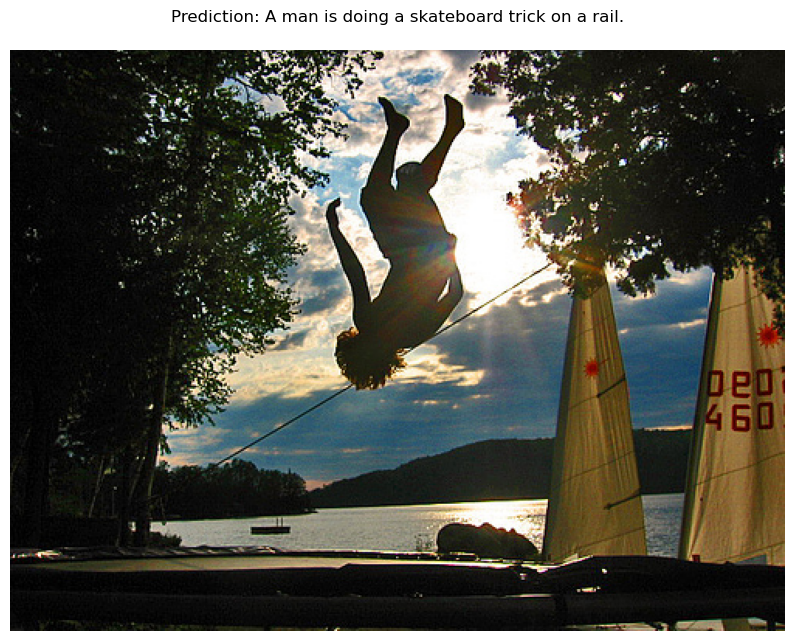


IMAGE ID: 2207244634_1db1a1890b.jpg

🧠 MODEL PREDICTION (Beam Search):
   → A man doing a skateboard trick on a skateboard.

📝 GROUND TRUTH CAPTIONS:
   1. a man wearing a red helmet jumps up while riding a skateboard
   2. a young man wearing a red jacket performs a jump on a red skateboard
   3. the helmeted boy is doing a stunt on a skateboard
   4. the young man is skateboarding at a skate park
   5. young man is performing a trick on a skateboard in a park



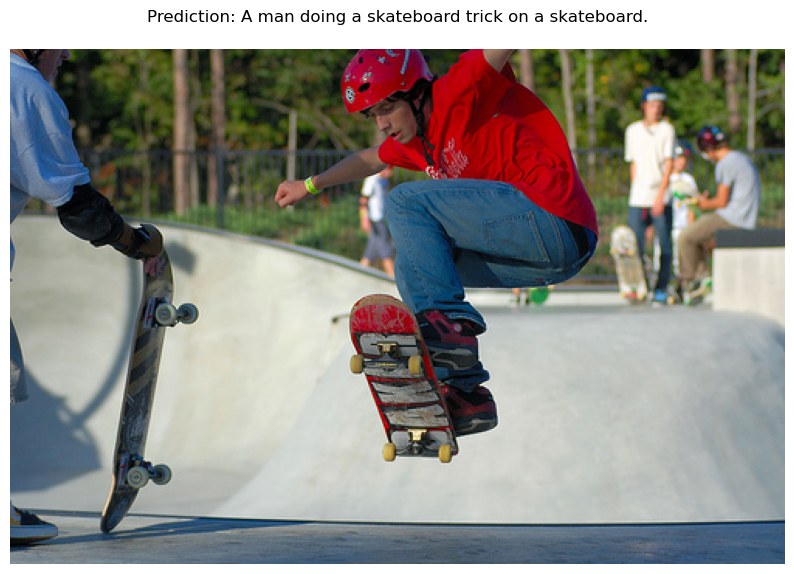


IMAGE ID: 3030566410_393c36a6c5.jpg

🧠 MODEL PREDICTION (Beam Search):
   → A girl in a swimming pool.

📝 GROUND TRUTH CAPTIONS:
   1. a child held by his mother slides down a water slide
   2. a woman holding a young boy slide down a water slide into a pool
   3. a woman is holding up a child as they coming splashing down a slide into a pool
   4. a woman is sliding down a water slide with a little boy on her lap
   5. a woman slides down a purple water slide with a small boy on her lap into a pool



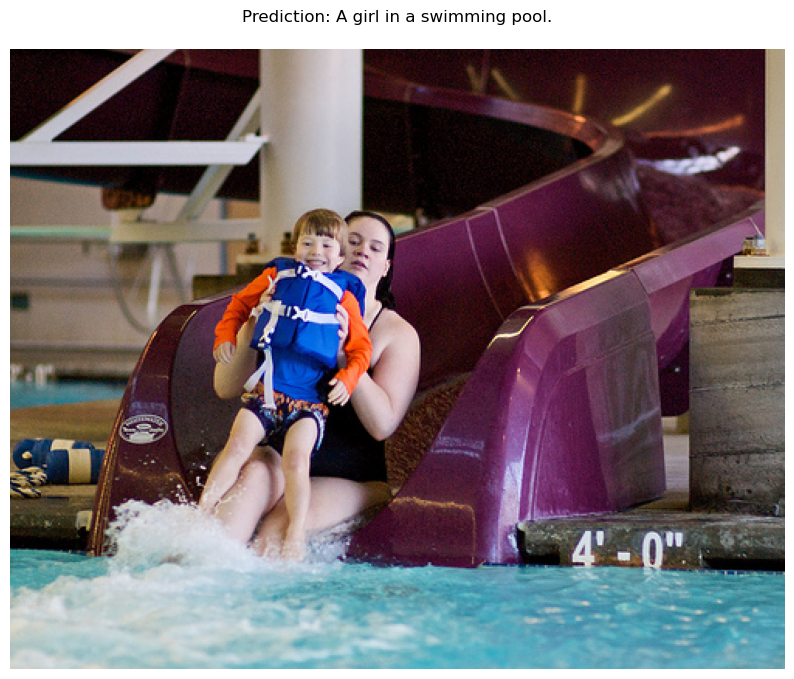


IMAGE ID: 2238019823_79318d1f11.jpg

🧠 MODEL PREDICTION (Beam Search):
   → A group of people standing on a ledge overlooking the water.

📝 GROUND TRUTH CAPTIONS:
   1. a man surfs by the golden gate bridge on a foggy day
   2. a surfer rides a wave under a red bridge
   3. a surfer by a bridge in foggy conditions
   4. a surfer under a bridge
   5. man surfing under the golden gate bridge on a foggy day



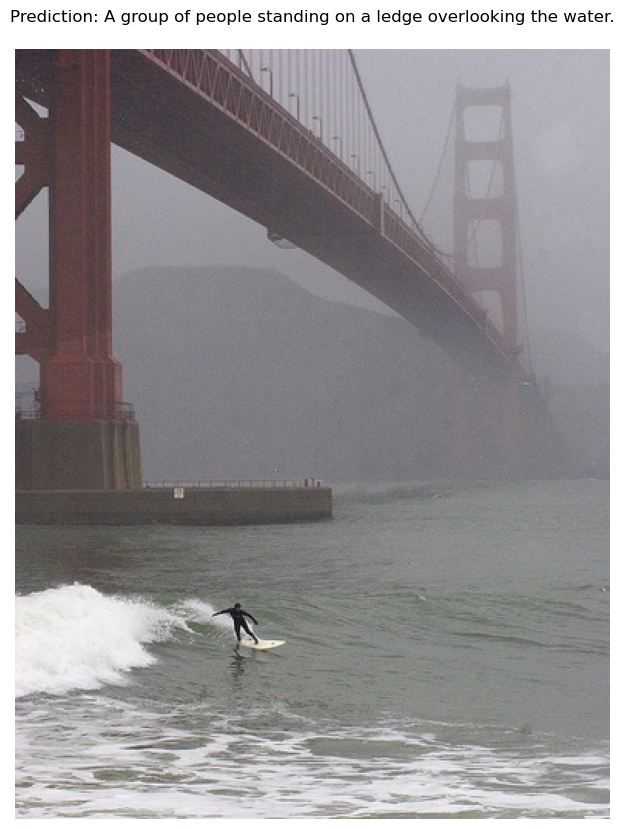


IMAGE ID: 300550441_f44ec3701a.jpg

🧠 MODEL PREDICTION (Beam Search):
   → A group of people are sitting on a park bench.

📝 GROUND TRUTH CAPTIONS:
   1. a woman in a skirt walks down a path
   2. a woman walks on boards
   3. a woman with a scarf on her head walks down a wooden boardwalk
   4. several people in a park walking on a low wooden boardwalk
   5. the woman wearing the brown skirt is carrying a black bag along a wooden walkway



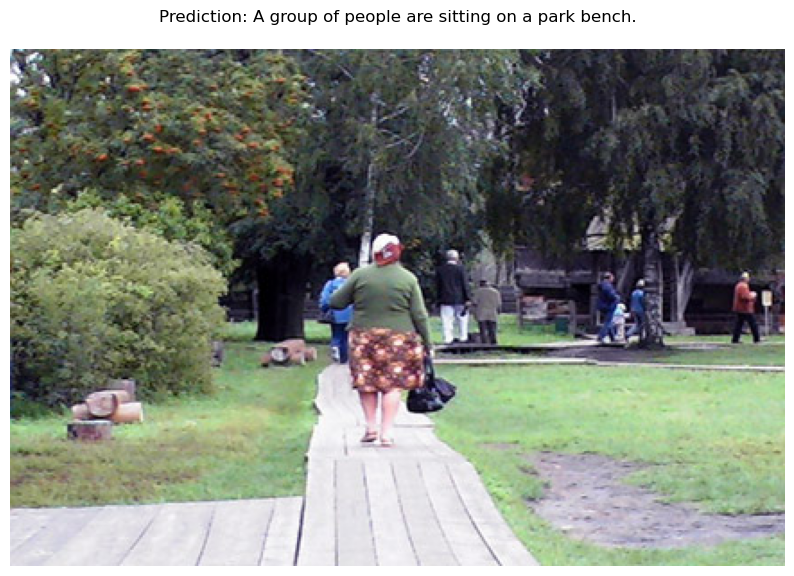

In [12]:

import random

random_test_images = random.sample(list(test_images), 5)

for img_id in random_test_images:
    Metrics.visualize_model_output_beam(
        model,
        img_id,
        image_features,
        img_cap_dict,
        wtoi,
        itow,
        device,
        image_dir="./data/images/",
        beam_size=5,
        max_len=20,
        length_norm_alpha=0.7
    )
